In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import random

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)


In [22]:
BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"

FEATURES_PATH = BASE / "features_all.csv"
SALES_PATH = BASE / "weekly_sales.csv"
SKU_PATH = BASE / "sku_catalog_ml_with_share.csv"

print("FEATURES:", FEATURES_PATH)
print("SALES   :", SALES_PATH)
print("SKU     :", SKU_PATH)


FEATURES: C:\Users\chosw\ORDER101_210_refact_jupyter\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\features_all.csv
SALES   : C:\Users\chosw\ORDER101_210_refact_jupyter\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\weekly_sales.csv
SKU     : C:\Users\chosw\ORDER101_210_refact_jupyter\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\sku_catalog_ml_with_share.csv


In [23]:
df_feat = pd.read_csv(FEATURES_PATH, parse_dates=["target_date"])
df_sales = pd.read_csv(SALES_PATH, parse_dates=["target_date"])
df_sku = pd.read_csv(SKU_PATH)

print("전체 Features row:", len(df_feat))

# 2025년 이전만 사용 (2021~2024)
df_feat_train = df_feat[df_feat["target_date"] < "2025-01-01"].copy()

print("Train rows:", len(df_feat_train))
df_feat_train.head()


전체 Features row: 51294
Train rows: 40582


,target_date,warehouse_id,store_id,sku_id,actual_order_qty,product_code,cat_low,brand,minor_option,msrp_krw,...,sin_week,cos_week,lag_1,lag_2,lag_4,lag_8,lag_12,ma_4,ma_8,ma_12
0,2021-03-29,1,1,1,38,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,1.000000,-1.608123e-16,32.0,40.0,39.0,26.0,0.0,37.50,34.250,28.416667
1,2021-04-05,1,1,1,50,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,0.992709,-1.205367e-01,38.0,32.0,39.0,33.0,18.0,37.25,35.750,31.583333
2,2021-04-12,1,1,1,47,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,0.970942,-2.393157e-01,50.0,38.0,40.0,27.0,26.0,40.00,37.875,34.250000
3,2021-04-19,1,1,1,41,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,0.935016,-3.546049e-01,47.0,50.0,32.0,38.0,23.0,41.75,40.375,36.000000
4,2021-04-26,1,1,1,38,TV-SAM-55인치-4K-00001,TV,Samsung,55인치-4K,3670000.0,...,0.885456,-4.647232e-01,41.0,47.0,38.0,39.0,26.0,44.00,40.750,37.500000


In [24]:
df_feat_train.info()
df_feat_train.columns.tolist()


<class 'pandas.core.frame.DataFrame'>
Index: 40582 entries, 0 to 51241
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   target_date       40582 non-null  datetime64[ns]
 1   warehouse_id      40582 non-null  int64         
 2   store_id          40582 non-null  int64         
 3   sku_id            40582 non-null  int64         
 4   actual_order_qty  40582 non-null  int64         
 5   product_code      40582 non-null  object        
 6   cat_low           40582 non-null  object        
 7   brand             40582 non-null  object        
 8   minor_option      40582 non-null  object        
 9   msrp_krw          40582 non-null  float64       
 10  base_share        40582 non-null  float64       
 11  avg_temp_c        40582 non-null  float64       
 12  cdd               40582 non-null  float64       
 13  hdd               40582 non-null  float64       
 14  precip_mm         40582 non

['target_date',
 'warehouse_id',
 'store_id',
 'sku_id',
 'actual_order_qty',
 'product_code',
 'cat_low',
 'brand',
 'minor_option',
 'msrp_krw',
 'base_share',
 'avg_temp_c',
 'cdd',
 'hdd',
 'precip_mm',
 'heat_wave',
 'cold_wave',
 'year',
 'weekofyear',
 'month',
 'sin_week',
 'cos_week',
 'lag_1',
 'lag_2',
 'lag_4',
 'lag_8',
 'lag_12',
 'ma_4',
 'ma_8',
 'ma_12']

## 결측치 비율

In [25]:
df_feat_train.isna().mean().sort_values(ascending=False)

target_date         0.0
warehouse_id        0.0
store_id            0.0
sku_id              0.0
actual_order_qty    0.0
product_code        0.0
cat_low             0.0
brand               0.0
minor_option        0.0
msrp_krw            0.0
base_share          0.0
avg_temp_c          0.0
cdd                 0.0
hdd                 0.0
precip_mm           0.0
heat_wave           0.0
cold_wave           0.0
year                0.0
weekofyear          0.0
month               0.0
sin_week            0.0
cos_week            0.0
lag_1               0.0
lag_2               0.0
lag_4               0.0
lag_8               0.0
lag_12              0.0
ma_4                0.0
ma_8                0.0
ma_12               0.0
dtype: float64

In [26]:
y_col = "actual_order_qty"
print("Target column:", y_col)


Target column: actual_order_qty


## 판매량 분포 (히스토그램)

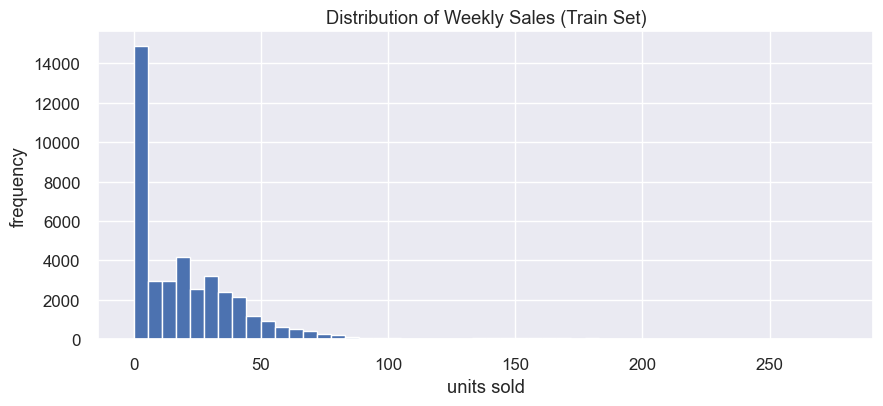

In [27]:
plt.figure(figsize=(10,4))
df_feat_train[y_col].hist(bins=50)
plt.title("Distribution of Weekly Sales (Train Set)")
plt.xlabel("units sold")
plt.ylabel("frequency")
plt.show()


## SKU별 총 판매량 Top 20

In [28]:
df_feat_train.groupby("sku_id")[y_col].sum().sort_values(ascending=False).head(20)


sku_id
202    32163
192    31758
197    30783
200    30318
70     14664
63     14299
71     13657
72     13539
74     13392
206    13358
205    13275
203    13203
204    12412
73     12390
62     11677
60     11178
61     11155
59     10951
146     8865
49      8803
Name: actual_order_qty, dtype: int64

## 전체 주간 판매량 트렌드

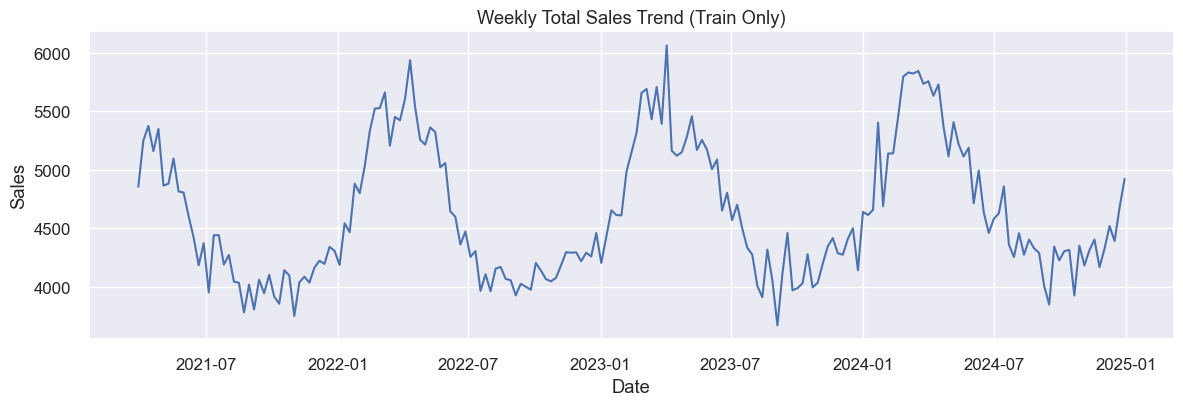

In [29]:
tmp = (
    df_feat_train.groupby("target_date")[y_col]
                  .sum()
                  .reset_index()
)

plt.figure(figsize=(14,4))
plt.plot(tmp["target_date"], tmp[y_col])
plt.title("Weekly Total Sales Trend (Train Only)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


## 월별 평균 판매량

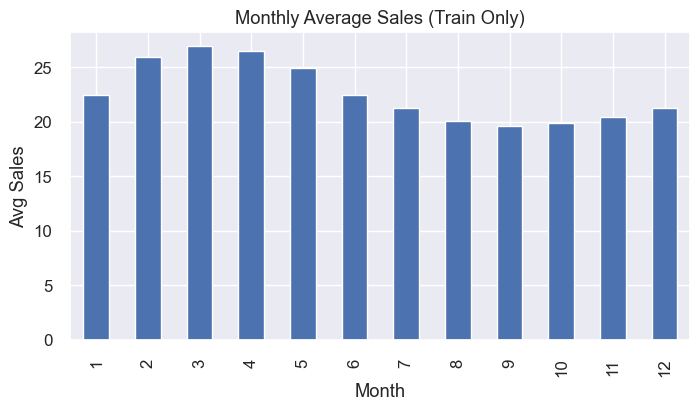

In [30]:
df_feat_train["month"] = df_feat_train["target_date"].dt.month

plt.figure(figsize=(8,4))
df_feat_train.groupby("month")[y_col].mean().plot(kind="bar")
plt.title("Monthly Average Sales (Train Only)")
plt.xlabel("Month")
plt.ylabel("Avg Sales")
plt.show()


## Feature 상관관계 Heatmap

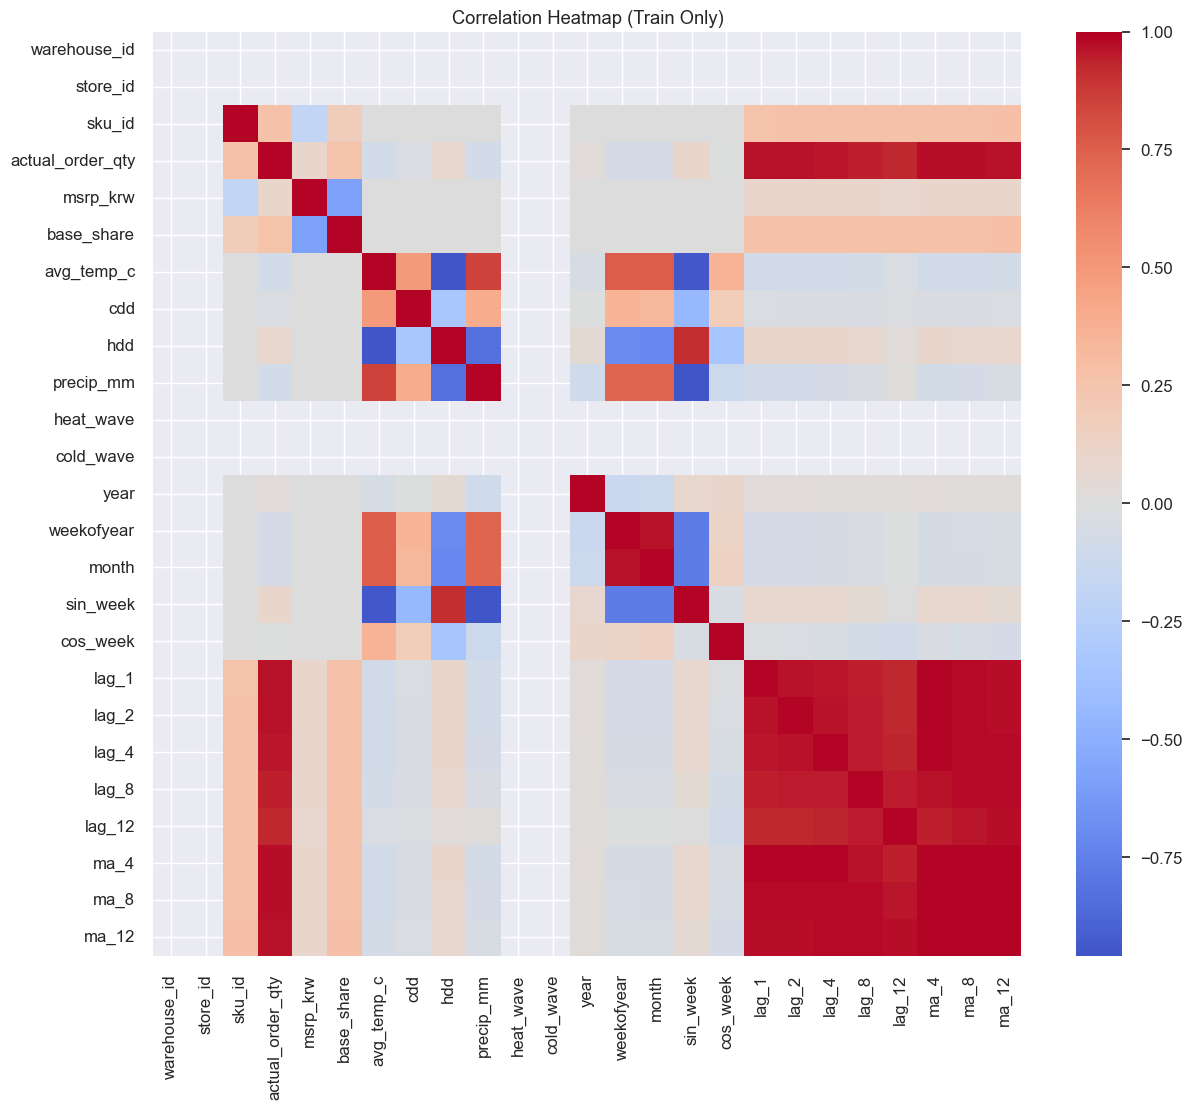

In [31]:
plt.figure(figsize=(14,12))
corr = df_feat_train.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Train Only)")
plt.show()


## 랜덤 SKU Deep-Dive 
시계열 판매량

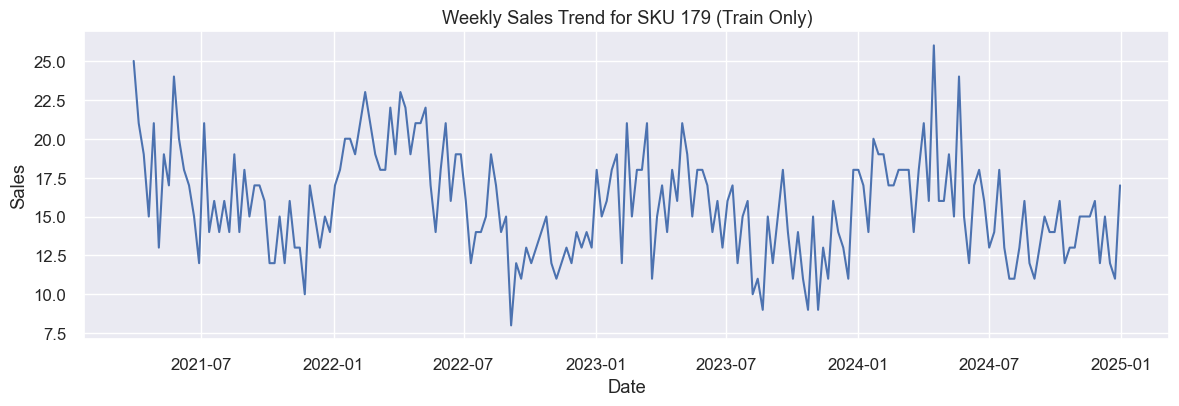

In [32]:
sample_sku = random.choice(df_feat_train["sku_id"].unique())

tmp = df_feat_train[df_feat_train["sku_id"] == sample_sku]

plt.figure(figsize=(14,4))
plt.plot(tmp["target_date"], tmp[y_col])
plt.title(f"Weekly Sales Trend for SKU {sample_sku} (Train Only)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


## SKU별 변동성(variance) 분석

In [33]:
sku_var = df_feat_train.groupby("sku_id")[y_col].var().sort_values(ascending=False)
sku_var.head(10)


sku_id
197    952.703046
202    950.827929
200    829.938620
192    811.665648
70     358.481923
71     350.567388
74     333.448565
63     331.264633
72     331.016316
73     279.442660
Name: actual_order_qty, dtype: float64

## Lag / MA Feature 분포 확인

In [34]:
feat_cols = ["lag_1", "lag_2", "lag_4", "lag_8", "lag_12",
             "ma_4", "ma_8", "ma_12"]

df_feat_train[feat_cols].describe()


,lag_1,lag_2,lag_4,lag_8,lag_12,ma_4,ma_8,ma_12
count,40582.000000,40582.000000,40582.000000,40582.000000,40582.000000,40582.000000,40582.000000,40582.000000
mean,22.464713,22.482948,22.520945,22.586886,22.496772,22.493402,22.531670,22.544757
std,27.737183,27.718827,27.664190,27.530835,27.401378,27.314423,27.140392,26.982184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.625000,0.750000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.250000,2.250000,2.333333
50%,16.000000,16.000000,16.000000,16.000000,16.000000,16.250000,16.375000,16.500000
75%,33.000000,33.000000,33.000000,33.000000,33.000000,33.500000,33.625000,33.833333
max,277.000000,277.000000,277.000000,277.000000,277.000000,228.750000,224.625000,213.583333


In [35]:
print("기간:", df_feat_train["target_date"].min(), "~", df_feat_train["target_date"].max())
print("SKU 수:", df_feat_train["sku_id"].nunique())
print("Store 수:", df_feat_train["store_id"].nunique())
print("Feature 수:", len(df_feat_train.columns))
print("평균 판매량:", df_feat_train[y_col].mean())
print("총 판매량:", df_feat_train[y_col].sum())


기간: 2021-03-29 00:00:00 ~ 2024-12-30 00:00:00
SKU 수: 206
Store 수: 1
Feature 수: 30
평균 판매량: 22.455226455078606
총 판매량: 911278
